In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    
    classification_report,
    precision_recall_curve
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
train_df = pd.read_csv('Train (1).csv')
test_df = pd.read_csv('Test (1).csv')

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74005 entries, 0 to 74004
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      74005 non-null  object 
 1   latitude                                                  74005 non-null  float64
 2   longitude                                                 74005 non-null  float64
 3   year                                                      74005 non-null  int64  
 4   week_no                                                   74005 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  72075 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              72075 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            72075 non-null  float64
 8   SulphurDioxide_c

In [12]:
train_df.isnull().sum()

ID_LAT_LON_YEAR_WEEK             0
latitude                         0
longitude                        0
year                             0
week_no                          0
                              ... 
Cloud_sensor_azimuth_angle    2724
Cloud_sensor_zenith_angle     2724
Cloud_solar_azimuth_angle     2724
Cloud_solar_zenith_angle      2724
emission                         0
Length: 76, dtype: int64

In [13]:
train_df.duplicated().sum()

0

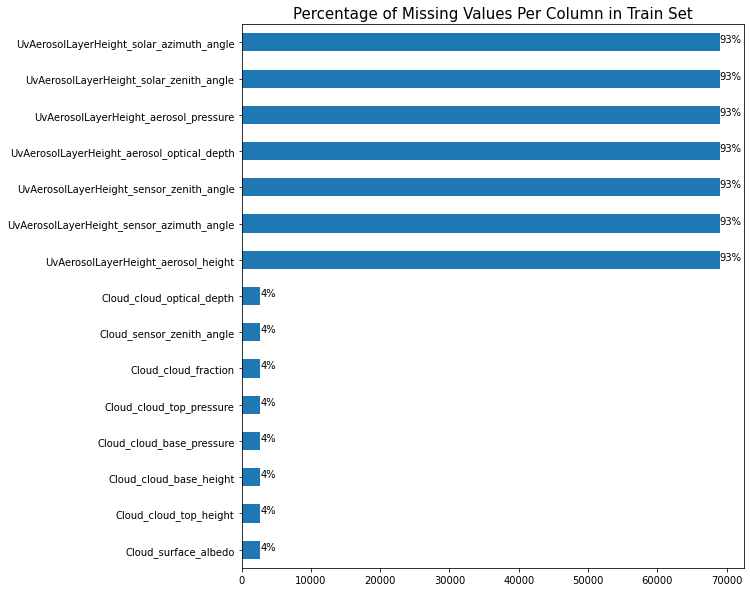

In [42]:
# Plot missing values in train set
ax = train_df.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train_df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

# Reducing Memory Function

In [3]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        
        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')
        
        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)  
        
    return df

In [8]:
#reducing memory of the train and test set
train_df = convert_types(train_df)
test_df = convert_types(test_df)

In [9]:
#removing missing values greater than a set threshold
def remove_nans(train,thresh) :
  def nans_rate(train,col) :
    return train[col].isna().sum() / train.shape[0]

  for col in train.columns : 
    if nans_rate(train,col) >= thresh :
      train.drop(col,axis=1,inplace=True)
  return train

In [10]:
train_df = remove_nans(train_df,thresh=0.8)
test_df = test_df[train_df.columns[:-1]]

In [85]:
cols_to_impute = ['Cloud_cloud_fraction', 'Cloud_cloud_optical_depth', 'Cloud_sensor_zenith_angle','Cloud_cloud_top_pressure','Cloud_cloud_base_pressure','Cloud_cloud_base_height','Cloud_cloud_top_height','Cloud_surface_albedo']

# impute missing values with the mean
train_df[cols_to_impute] = train_df[cols_to_impute].fillna(train_df[cols_to_impute].mean())

In [162]:
train_df = train_df.fillna(train_df.mean())

<ipython-input-162-987e9d6ebd2a>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df = train_df.fillna(train_df.mean())


In [11]:
print(train_df.shape)
print(test_df.shape)

(74005, 69)
(28085, 68)


In [163]:
train_df['location'] = [str(x) + '_' + str(y) for x, y in zip(train_df.latitude, train_df.longitude)]

# Filter based on one location
example_loc = train_df[train_df.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Feature engineering train
train_roll_mean = train_df.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train_df.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

In [164]:
train_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000110,0.836608,-0.000100,0.120665,1.693459,37.789164,-87.746208,21.980407,-4.893006e-05,0.023943,...,67339.232255,2923.948277,73729.746445,2233.972124,9.140701,0.245044,40.384742,38.662114,-86.749784,20.105273
2,0.000043,0.641295,0.000012,0.103777,-13.385948,52.846782,-83.746759,23.169268,1.937504e-08,0.023028,...,65071.221871,2989.119103,71780.273158,2155.997752,6.225485,0.228003,75.986498,47.516017,-77.745991,14.707559
3,0.000009,0.694835,-0.000019,0.147949,-28.140775,44.791620,-77.652041,24.530630,-1.477187e-05,0.023304,...,64430.413148,2892.314172,72962.216146,2081.063349,8.244984,0.264330,33.810803,61.167557,-69.656094,17.795747
4,-0.000178,0.911796,-0.000146,0.193445,16.524428,37.339700,-65.317669,22.341699,-6.871206e-05,0.024523,...,68163.889903,2477.002215,76372.791637,1718.503402,17.818609,0.285030,3.993070,51.144645,-64.468878,22.633834


In [165]:
# Feature engineering test
test = pd.read_csv('Test (1).csv')
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000129,0.438820,0.000048,0.094695,-49.026000,55.935104,-92.364110,26.771698,0.000020,0.025489,...,79559.852761,1581.442797,85797.362245,1244.571120,7.992071,0.259796,17.630362,45.737880,-89.109364,18.387366
2,0.000120,0.568128,0.000053,0.094655,-0.520018,44.992116,-88.070204,21.958601,0.000022,0.025030,...,81572.572154,1282.791996,87845.400932,966.944666,6.034695,0.248807,71.207042,49.737372,-84.134505,14.844741
3,0.000271,0.573770,0.000107,0.122802,-2.874843,47.106180,-82.843573,22.253363,0.000044,0.023687,...,70029.205187,2759.192458,76436.591607,2217.600819,6.526499,0.270112,32.449978,51.013410,-80.515631,19.533481
4,0.000338,0.608749,0.000156,0.146268,-8.862492,49.323300,-77.793343,22.962163,0.000066,0.022966,...,69815.083489,2791.479253,75984.387202,2275.478810,9.021939,0.281553,-12.158872,55.848501,-77.192182,22.996102


In [166]:
train_eng = train_df.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53,27.47,2019,1,0.000077,0.454468,0.000034,0.114291,-80.286309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.53_27.47_2019_2,-23.53,27.47,2019,2,0.000181,0.423171,0.000062,0.075100,-17.765690,...,79559.852761,1581.442797,85797.362245,1244.571120,7.992071,0.259796,17.630362,45.737880,-89.109364,18.387366
2,ID_-23.53_27.47_2019_3,-23.53,27.47,2019,3,0.000059,0.713085,0.000043,0.114210,16.725653,...,81572.572154,1282.791996,87845.400932,966.944666,6.034695,0.248807,71.207042,49.737372,-84.134505,14.844741
3,ID_-23.53_27.47_2019_4,-23.53,27.47,2019,4,0.000483,0.434454,0.000171,0.131394,-22.475340,...,70029.205187,2759.192458,76436.591607,2217.600819,6.526499,0.270112,32.449978,51.013410,-80.515631,19.533481
4,ID_-23.53_27.47_2019_5,-23.53,27.47,2019,5,0.000193,0.783044,0.000141,0.161142,4.750356,...,69815.083489,2791.479253,75984.387202,2275.478810,9.021939,0.281553,-12.158872,55.848501,-77.192182,22.996102


In [167]:
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

In [168]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [127]:
y_train.head()

928      1620.52330
49596     247.76147
11859     867.04660
4516      925.04900
71639    7144.56900
Name: emission, dtype: float64

In [139]:

#function to calculate model performance using Rsquared and RMSE
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_predictions(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

In [140]:
from sklearn.model_selection import cross_val_score, KFold
print('Train Shape:',X_train.shape)
print('Test Shape:',X_test.shape)

Train Shape: (51803, 144)
Test Shape: (22202, 144)


In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [73]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
# Random Forest Regressor
regressor = RandomForestRegressor(n_estimators = 2000,max_depth=2)

# Fitting the model
regressor.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred = regressor.predict(x_test_scaled)
# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

RMSE:  47979.77861758345
R-squared:  0.10690579855044968


In [141]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
#fitting the model
xgb_model.fit(X_train, y_train)
# Make predictions on the test data

y_pred = xgb_model.predict(X_test)
# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)
     

RMSE:  34099.3129843097
R-squared:  0.6031591362168134


In [145]:
#fitting lightGBM
import lightgbm as lgb

# Define the dataset format for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters for the model
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mae',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 1
}
#training the model
lgb_model = lgb.train(params, train_data, num_boost_round=100)

y_pred = lgb_model.predict(X_test)
# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35888
[LightGBM] [Info] Number of data points in the train set: 51803, number of used features: 144
[LightGBM] [Info] Start training from score 7769.888273
RMSE:  12644.992491287465
R-squared:  0.9454289538359816


In [109]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.3 MB/s eta 0:00:00


In [171]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSE')
cat_model.fit(X_train, y_train, verbose=False)

y_pred = cat_model.predict(X_test)
# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

RMSE:  4397.369111441289
R-squared:  0.9934005009463743


In [175]:
from sklearn.model_selection import GridSearchCV

cat_model = CatBoostRegressor(loss_function='RMSE', verbose=False)

param_grid = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.1, 0.5]
}

grid_search = GridSearchCV(cat_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_cat_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the testing data
y_pred = best_cat_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("Best parameters: ", best_params)
print("RMSE: ", rmse)

Best parameters:  {'iterations': 2000, 'learning_rate': 0.1}
RMSE:  4195.642738055827


In [177]:
best_params = grid_search.best_params_

best_iterations = best_params['iterations']
best_learning_rate = best_params['learning_rate']

best_cat_model = CatBoostRegressor(iterations=best_iterations, learning_rate=best_learning_rate, loss_function='RMSE', verbose=False)

best_cat_model.fit(X_train, y_train)

# Evaluate the best model on the testing data
y_pred = best_cat_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)


RMSE:  4195.642738055827
R-squared:  0.9939921078313473


In [178]:
# Make prediction on the test set
test = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = best_cat_model.predict(test)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
# Create file
sub_file.to_csv('BaselineSubmissioncat2.csv', index = False) 
from google.colab import files
files.download('BaselineSubmissioncat2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [174]:
from google.colab import files
files.download('BaselineSubmissioncat2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [146]:
from sklearn.tree import DecisionTreeRegressor
# decision tree regresison on original data
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
dt_pruned = DecisionTreeRegressor(max_depth=5)
dt_pruned.fit(X_train,y_train)

y_pred = dt_pruned.predict(X_test)
# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE: ", rmse)
print("R-squared: ", r2)

RMSE:  24983.065095044574
R-squared:  0.786981870374016


In [113]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

LinReg = LinearRegression()

# Perform cross-validation with 5 folds
scoring = ['neg_mean_squared_error', 'r2']
cv_scores = cross_validate(LinReg, X_train, y_train, cv=10, scoring=scoring)

# Calculate the RMSE and R-squared from the cross-validation scores
rmse_cv = np.sqrt(-cv_scores['test_neg_mean_squared_error'].mean())
r2_cv = cv_scores['test_r2'].mean()

# Print the results
print("Cross-validation RMSE: ", rmse_cv)
print("Cross-validation R-squared: ", r2_cv)
     

Cross-validation RMSE:  48965.30570294872
Cross-validation R-squared:  0.10993157519234042


In [147]:

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

#define the model
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()
     

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               18560     
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 183,425
Trainable params: 183,425
Non-trainable params: 0
_________________________________________________________________


In [148]:
checkpoint_name = 'best_model1.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [149]:
NN_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/30
1288/1296 [============================>.] - ETA: 0s - loss: 7862.0786 - mean_absolute_error: 7862.0786
Epoch 1: val_loss improved from inf to 6691.80176, saving model to best_model1.hdf5
1296/1296 [==============================] - 6s 4ms/step - loss: 7863.4004 - mean_absolute_error: 7863.4004 - val_loss: 6691.8018 - val_mean_absolute_error: 6691.8018
Epoch 2/30
1288/1296 [============================>.] - ETA: 0s - loss: 7792.0444 - mean_absolute_error: 7792.0444
Epoch 2: val_loss did not improve from 6691.80176
1296/1296 [==============================] - 5s 4ms/step - loss: 7774.6626 - mean_absolute_error: 7774.6626 - val_loss: 6700.7222 - val_mean_absolute_error: 6700.7222
Epoch 3/30
1283/1296 [============================>.] - ETA: 0s - loss: 7768.1284 - mean_absolute_error: 7768.1284
Epoch 3: val_loss improved from 6691.80176 to 6687.18994, saving model to best_model1.hdf5
1296/1296 [==============================] - 5s 4ms/step - loss: 7771.2603 - mean_absolute_error

In [151]:
from keras.models import load_model
# Load the saved model
saved_model = load_model('best_model1.hdf5')
# Make predictions on the testing data
y_pred = saved_model.predict(X_test)

# Calculate the RMSE and R-squared on the testing data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("RMSE:", rmse)
print("R-squared:", r2)
     

694/694 [==============================] - 1s 2ms/step
RMSE: 54658.05355247871
R-squared: -0.019608510111539523
